In [181]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import re

In [182]:
#import data from csv
edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
hero_edges = pd.read_csv('hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [183]:
hero_edges.describe()

,hero1,hero2
count,574467,574467
unique,6211,6173
top,CAPTAIN AMERICA,CAPTAIN AMERICA
freq,8149,8350


In [184]:
#Let's display the number of different nodes (comic/hero)
pd.DataFrame(nodes.type.value_counts())

,type
comic,12651
hero,6439


- **DATA CLEANING**

In [185]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [186]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [187]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [188]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [189]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


- *FIRST GRAPH*

In [190]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [191]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

C:\Users\Admin\AppData\Local\Temp\ipykernel_12836\1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [192]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [193]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

In [194]:
nx.degree_centrality(heroes)
pd.DataFrame.from_dict(nx.betweenness_centrality(heroes,k= 10), orient='index', columns=['betweenness']).sort_values(by='betweenness', ascending=False).head(10)

,betweenness
HAVOK/ALEX SUMMERS,0.108190
CAPTAIN AMERICA,0.099355
IRON MAN/TONY STARK,0.074925
DR. STRANGE/STEPHEN,0.064459
HAWK,0.048708
DAREDEVIL/MATT MURDO,0.047385
SPIDER-MAN/PETER PAR,0.037649
THING/BENJAMIN J. GR,0.035118
BEAST/HENRY &HANK& P,0.033792
MARVEL GIRL/JEAN GRE,0.026849


- SECOND GRAPH

In [195]:
node_data = list(zip(nodes.node, [t for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [196]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
edge_data = [(e[0], e[1])for e in edge_arr.tolist()] # again format of list of tuples
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [1]:
#build the graph
comics=nx.Graph()

# Add nodes to the graph
for node, node_type in node_data:
    comics.add_node(node, type=node_type) 
    
# Add edges to the graph
comics.add_edges_from(edge_data)

#check the type
comics.nodes['2001 10']['type']

NameError: name 'nx' is not defined

In [200]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

FUNCTIONALITY 1



Output:

- The number of nodes in the network (if type 2, report for both node types)

- The number of collaborations of each superhero with the others (only if type 1)

- The number of heroes that have appeared in each comic (only if type 2)

- The network's density

- The network's degree distribution

- The average degree of the network

- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
Whether the Network is sparse or dense

In [201]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby('hero')['comic'].count().sort_values(ascending=False).reset_index().head(10)
ls

,hero,comic
0,SPIDER-MAN/PETER PAR,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
5,HUMAN TORCH/JOHNNY S,886
6,MR. FANTASTIC/REED R,854
7,HULK/DR. ROBERT BRUC,835
8,WOLVERINE/LOGAN,819
9,INVISIBLE WOMAN/SUE,762


In [202]:
#build a function to extract the nodes that are not in the top N

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N

    top = edges_cleaned.groupby('hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = list(top[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)


#check 
graph_without_notTopN= Remove_Not_TopN(heroes,100) 
nx.info(graph_without_notTopN)
nx.density(graph_without_notTopN) #dense graph 

C:\Users\Admin\AppData\Local\Temp\ipykernel_12836\238848.py:18: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(graph_without_notTopN)


0.8141414141414142

In [203]:
#1)     #The number of nodes in the network (if type 2, report for both node types)
def n_nodes_N(graph,type_):  
    if type_== 1:
        print('the number of nodes of the original network is '+ str(graph.number_of_nodes()), end='\n')

    elif type_==2:

        comic=[x for x in graph.nodes if graph.nodes[x]['type']=="comic"]
        print('the number of hero-nodes is '+ str(len(comic)))
        hereos=[x for x in graph.nodes if graph.nodes[x]['type']=='hero']
        print('the number of comic-nodes is '+ str(len(hereos)))

#check
n_nodes_N(comics,2)

the number of hero-nodes is 12648
the number of comic-nodes is 6439


In [204]:
#2) The number of collaborations of each hero with the others 

def collaborations(graph,type_):
    if type_ == 1:
        collabor=dict(graph.degree())
        collab=dict(sorted(collabor.items(),key=lambda x: -x[1]))
    #let's print just the first 25 pairs of the dictionary:
        count = 0
        for key, value in collab.items():
            print(f'{key}: {value}')
            count += 1
            if count >= 10:
                break
                  
                
#3) this request can be interpreted as find the degree of each 'comic'-node 
def hero_appearance(graph,type_):
    #dictionary comprehension 
    if  type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'}
        comic
        # sort the dictionary by values and store the result as a dataframe
        sort_dict = sorted(comic.items(), key=lambda x: -x[1])
        top10_comic_degree= pd.DataFrame(sort_dict).head(10)

    return(top10_comic_degree.rename(columns={0: 'Comic', 1: 'Degree'}))



#construct a function to call one of the previous two depending on the type of graph given as input
def collaborations_appearances(graph,type_):
    if type_==1:
        print('The number of collaborations of each superhero with the others is: ')
        collaborations(graph,1)
    elif type_==2:
        print('The number of heroes that have appeared in each comic is: ')
        print(hero_appearance(graph,2))
        

In [205]:
collaborations_appearances(comics,2)

The number of heroes that have appeared in each comic is: 
      Comic  Degree
0     COC 1     111
1      IW 3      91
2      IW 1      90
3    H2 279      87
4      IW 4      80
5      IW 2      76
6  MAXSEC 3      72
7    FF 370      62
8      IW 6      60
9    M/GN 1      60


In [206]:
#4) density of the graph

def density(graph):
    dens = nx.density(graph)
    print('The Density of the graph is ' + str(round(dens,4)))


#check
density(comics)

The Density of the graph is 0.0005


In [207]:
#5) EXTRACT NETWORK'S DEGREE DISTRIBUTION

#To extract the degree distribution of the graph we have to iterate through all the nodes and count 
#for each node its number of edges(degree), then we will use the degree as the key and the number of 
#nodes with that degree as the value in the dictionary

def degree_distribution(graph):
    degree_count={}
    for node in graph.nodes():
        degree=graph.degree(node)
        if degree not in degree_count:  #if the degree of the node it's not even encountred before assign 1
            degree_count[degree] = 1
        else:
            degree_count[degree] += 1 #if the degree has already been encountered, increment the value by 1.
            
    output=dict(sorted(degree_count.items())) #degree distribution sorted by keys (degrees of the nodes)
    print(output)
#claim that in this dict we have as key the various degrees of node and as values the number of nodes that have that degree


In [208]:
degree_distribution(heroes)

{1: 52, 2: 86, 3: 104, 4: 150, 5: 182, 6: 178, 7: 185, 8: 230, 9: 224, 10: 246, 11: 254, 12: 186, 13: 193, 14: 160, 15: 193, 16: 123, 17: 143, 18: 123, 19: 109, 20: 131, 21: 118, 22: 84, 23: 94, 24: 85, 25: 111, 26: 70, 27: 85, 28: 64, 29: 72, 30: 65, 31: 49, 32: 43, 33: 46, 34: 56, 35: 44, 36: 45, 37: 39, 38: 60, 39: 61, 40: 38, 41: 46, 42: 39, 43: 30, 44: 38, 45: 27, 46: 39, 47: 20, 48: 57, 49: 33, 50: 30, 51: 18, 52: 21, 53: 20, 54: 27, 55: 25, 56: 25, 57: 18, 58: 24, 59: 30, 60: 25, 61: 22, 62: 14, 63: 10, 64: 22, 65: 20, 66: 20, 67: 16, 68: 23, 69: 22, 70: 16, 71: 14, 72: 14, 73: 28, 74: 10, 75: 6, 76: 13, 77: 17, 78: 16, 79: 21, 80: 13, 81: 16, 82: 7, 83: 11, 84: 14, 85: 11, 86: 16, 87: 11, 88: 8, 89: 18, 90: 11, 91: 9, 92: 9, 93: 6, 94: 12, 95: 5, 96: 9, 97: 8, 98: 8, 99: 4, 100: 9, 101: 6, 102: 8, 103: 3, 104: 4, 105: 7, 106: 9, 107: 4, 108: 8, 109: 6, 110: 10, 111: 6, 112: 3, 113: 4, 114: 5, 115: 2, 116: 4, 117: 7, 118: 9, 119: 6, 120: 11, 121: 2, 122: 8, 123: 9, 124: 5, 125: 

In [209]:
#6)  # Calculate the average degree of the graph
def avg_G(graph):
    average_degree = sum(d for n, d in graph.degree()) / graph.number_of_nodes()
    print("Average degree of the graph: "+str(round(average_degree,3)))
avg_G(comics)    

Average degree of the graph: 10.07


In [210]:
#7) 
def HUBS(graph,type_):
    #Calculate the 95th percentile of the degree distribution. To do this, 
    #first sort the degrees in ascending order and then find the degree at the 95th percentile:
    degrees=dict(graph.degree())
    sorted_degrees=sorted(degrees.values())
    #95th_percentile
    perc_95 = sorted_degrees[int(len(sorted_degrees) * 0.95)]
    #Find the nodes with degrees greater than the 95th percentile with a loop
    if type_==1:
        hubs = [node for node, degree in degrees.items() if degree > perc_95]
    #when computing hubs for the second graph, we care only about comics-type of nodes:
    elif type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'} #dict comprehension as above
        hubs = [node for node, degree in comic.items() if degree > perc_95 ] #take just nodes of comic-type
    
    hubs= pd.DataFrame(hubs).rename(columns={0:'HUBS'})
    # print the DataFrame without the row indices for a better visualization of the output
    return(hubs)#.to_string(index=False))

In [211]:
HUBS(comics,2).head(6)

,HUBS
0,A 10
1,A 118
2,A 12
3,A 15
4,A 16
5,A 173


- **DENSITY OF THE GRAPH**

The density of a graph is defined as the number of edges in the graph divided by the maximum number of edges that the graph could have. For example, if a graph has n vertices and there are e edges, the maximum number of edges that the graph could have is n(n-1)/2 (this is because each vertex can have an edge with every other vertex except itself). The density of the graph is then e / (n(n-1)/2).

Genereally, in many papers,a graph is considered sparse if its density is less than 0.1, and it is considered dense if its density is greater than 0.9.

For simplicity and to give a general index to the density of the graph we will set the threshold in this case to 0.5

In [212]:
#8)
def kind_G(graph):
    #sparsity of the graph, we take as trashold 0.5 value of the density of the graph
    density=nx.density(graph)
    if density>=0.5:
        print('The graph is dense')
    else:
        print('The graph is sparse')

In [213]:
#extract features from the graph

#build a function to extract the nodes that are not in the top N

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N
    
    top = edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (top[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    graph=graph.copy()
    graph.remove_nodes_from(not_top_heroes) 
    return(graph)
    


In [218]:


def functionality_1(graph_,type_, N):
    
    #takes N heroes with the above function
    graph=Remove_Not_TopN(graph_,N)
    
    # print the outputs of the functions together and separated using concatenation
    print('• Results of the query of the user: ')
    print('--------------------------------------')
    n_nodes_N(graph_,type_) 
    print('--------------------------------------')
    collaborations_appearances(graph,type_)
    print('--------------------------------------')
    density(graph)
    print('--------------------------------------')
    print('The degree distribution of the graph is: ')
    degree_distribution(graph)
    print('--------------------------------------')
    avg_G(graph)
    print('--------------------------------------')
    print(HUBS(graph,type_))
    print('--------------------------------------')
    kind_G(graph)
  

In [219]:
functionality_1(heroes,1,150)

• Results of the query of the user: 
--------------------------------------
the number of nodes of the original network is 6421
--------------------------------------
The number of collaborations of each superhero with the others is: 
CAPTAIN AMERICA: 149
MR. FANTASTIC/REED R: 148
HUMAN TORCH/JOHNNY S: 148
SPIDER-MAN/PETER PAR: 147
THING/BENJAMIN J. GR: 147
INVISIBLE WOMAN/SUE: 147
IRON MAN/TONY STARK: 146
THOR/DR. DONALD BLAK: 146
VISION: 144
BEAST/HENRY &HANK& P: 144
--------------------------------------
The Density of the graph is 0.6958
--------------------------------------
The degree distribution of the graph is: 
{44: 1, 45: 1, 46: 1, 48: 1, 52: 1, 54: 1, 55: 1, 57: 2, 60: 2, 62: 1, 64: 2, 65: 2, 66: 1, 67: 1, 68: 1, 69: 1, 71: 2, 72: 3, 73: 2, 76: 1, 79: 3, 80: 2, 81: 1, 82: 5, 83: 2, 84: 2, 85: 2, 87: 1, 88: 3, 89: 1, 92: 1, 93: 2, 95: 3, 96: 1, 97: 1, 98: 1, 99: 2, 100: 2, 101: 2, 102: 1, 103: 5, 104: 3, 105: 4, 106: 4, 107: 3, 108: 1, 109: 1, 110: 2, 111: 4, 113: 3, 114: 5,

**VISUALIZATION 1- Visualize some features of the network**

In [36]:
#1)
from tabulate import tabulate

#A table containing general information about the graph

def make_table(graph):
    
    # Create a list of lists representing the rows of the table
    n_nodes=graph.number_of_nodes()
    density=nx.density(graph)
    avg= sum(d for n, d in graph.degree()) / graph.number_of_nodes()
    
    kind=[]
    if density>=0.5:
        kind='dense'
    else:
        kind='sparse'
    
    
    rows = [    [n_nodes,density,avg,kind]  ]

    # Create a list of strings representing the column names
    columns = ["N.Nodes", "Density", "AVG_degree","Kind_Graph"]

    # Print the table
    print(tabulate(rows, headers=columns))

In [37]:
#check
make_table(comics)

  N.Nodes      Density    AVG_degree  Kind_Graph
---------  -----------  ------------  ------------
    19087  0.000527617       10.0701  sparse


In [143]:
#2)

def table_hubs(graph,type_): #devi trovare un modo per passargli N ed estarrre gli N da quel modo, non puoi mandare questa funzione 
    hub=HUBS(graph,type_)
    
    #hub=pd.DataFrame(hub).rename(columns={0:'Hubs'})
    
    print(hub)
    

In [144]:
table_hubs(heroes,1)

                     HUBS
0    BLACK PANTHER/T'CHAL
1     IRON MAN/TONY STARK
2    IRON MAN IV/JAMES R.
3        ROM, SPACEKNIGHT
4    MYSTIQUE/RAVEN DARKH
..                    ...
315  AJAK/TECUMOTZIN [ETE
316            SILHOUETTE
317  MADDICKS, ARTHUR ART
318  CHAMBER/JONOTHON STA
319                 LEECH

[320 rows x 1 columns]


In [110]:
#3)
#In order to have a better visualization we will show just the first 25 observation (in this case number of collaborations of each hero)

def depicting_collaborations(graph,type_): 
    if type_ == 1:
        # get the degree view object of the graph
        degrees = graph.degree()
        # convert the degree view object to a dictionary
        degrees_dict = dict(degrees)
        # sort the dictionary by descending order
        sorted_degrees = sorted(degrees_dict.items(), key=lambda x: -x[1])  
        top_25 = sorted_degrees[:25]
        
        keys, values = zip(*top_25)

        # Create the histogram
        plt.bar(keys,values,edgecolor='black',color='lightblue')

        # Add a title and labels for the x and y axes
        plt.title('Number of collaborations of each hero')
        plt.xlabel('Hereos')
        plt.ylabel('Number of Collaborations')
        
        # Rotate the x-axis tick labels 90 degrees in order to be alble to see the hero names
        plt.xticks(rotation=90)

        plt.show()

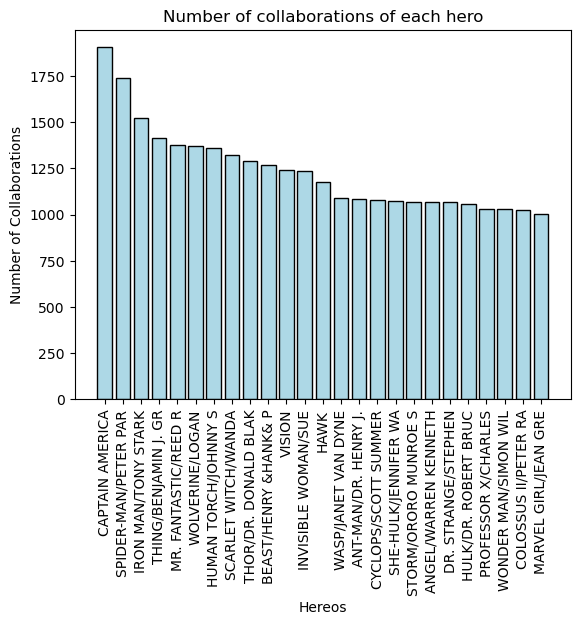

In [111]:
depicting_collaborations(heroes,1)

In [112]:
#4)

def depicting_heroes_in_comic(graph,type_): 
    if type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'}
        # sort the dictionary by values and store the result as a dataframe
        sort_dict = sorted(comic.items(), key=lambda x: -x[1])
        top25_comic= sort_dict[:25]
        #Extract the keys and values into separate lists
        keys, values = zip(*top25_comic)

        # Create the histogram
        plt.bar(keys,values,edgecolor='black',color='lightblue')

        # Add a title and labels for the x and y axes
        plt.title('Hereos apparitions for each comic')
        plt.xlabel('Comic')
        plt.ylabel('Number of Heroes in the comic')

        # Rotate the x-axis tick labels 90 degrees in order to be alble to see the 'comic_code'
        plt.xticks(rotation=90)

 
        
        plt.show()

      

        

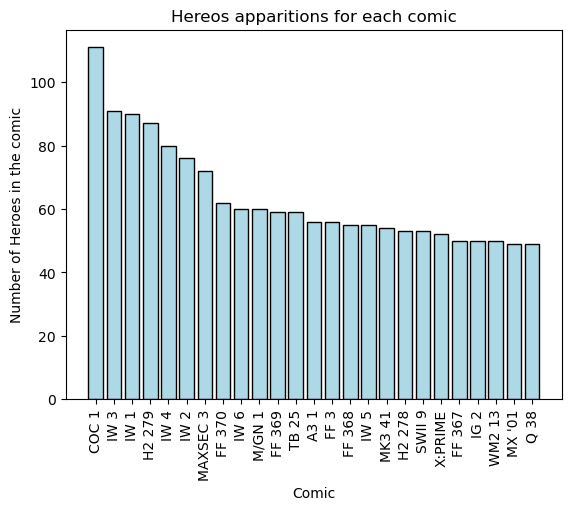

In [113]:
depicting_heroes_in_comic(comics,2)

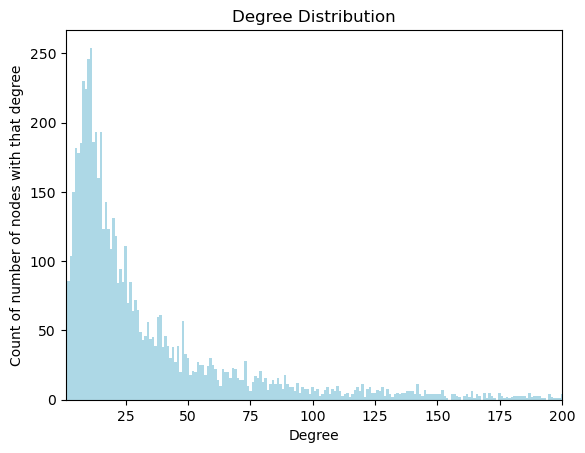

In [88]:
#5) degree distribution of the network
#visualize the dict sorted by its keys (degree of the nodes)

def depicting_distr_netw(graph):
    distribution=degree_distribution(graph)
    sort_distribution = dict(sorted(distribution.items(), key=lambda x: x[0]))

    #and let's visualize it with a suitable plot

    degrees, counts = zip(*sort_distribution.items())
    #return(type(sort_distribution))
    # Plot the histogram
    plt.bar(degrees, counts, width=1,color='lightblue')
    # Set the x-axis range in order to have a better visualization
    plt.xlim(1,200)
    plt.xlabel('Degree')
    plt.ylabel('Count of number of nodes with that degree')
    plt.title('Degree Distribution')

    plt.show()
    
depicting_distr_netw(heroes)

In [145]:
def visualization_1(graph_,type_,N):
    #takes N heroes with the above function
    graph=Remove_Not_TopN(graph_,N)
    
    print('• Report of the query of the user with visualizations: ', end='\n')
    
    make_table(graph) #this table is referred to the 
    print('')
    table_hubs(graph,type_)
    print('')
    if type_==2:
        depicting_heroes_in_comic(graph,type_)
    elif type_==1:
        depicting_collaborations(graph,type_)
    print('')
    depicting_distr_netw(graph)

• Report of the query of the user with visualizations: 
  N.Nodes    Density    AVG_degree  Kind_Graph
---------  ---------  ------------  ------------
      150   0.695839        103.68  dense

                   HUBS
0  SPIDER-MAN/PETER PAR
1       CAPTAIN AMERICA
2  MR. FANTASTIC/REED R
3  THING/BENJAMIN J. GR
4   INVISIBLE WOMAN/SUE
5  HUMAN TORCH/JOHNNY S



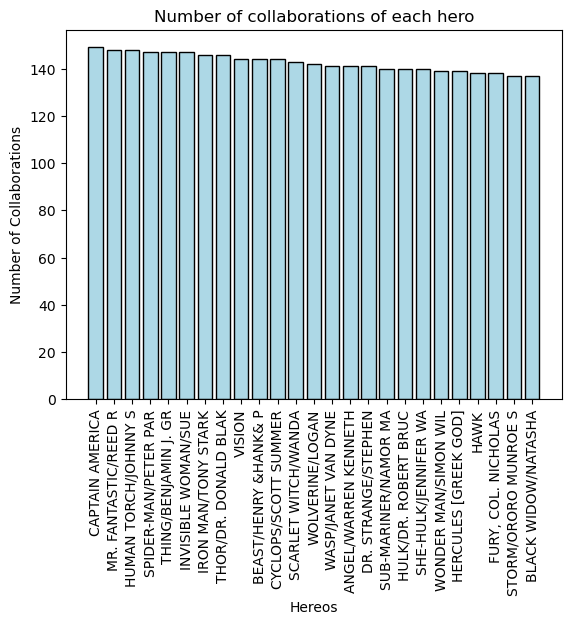

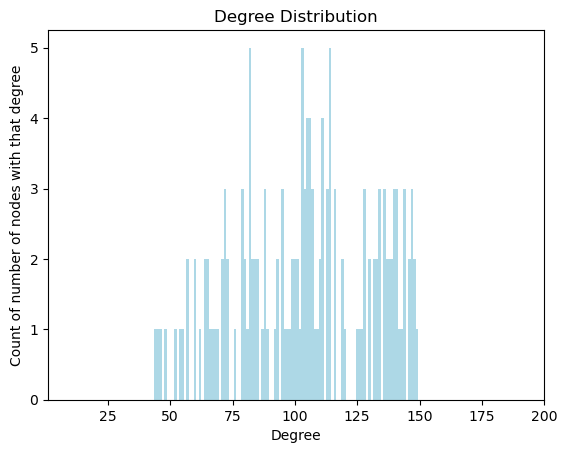

In [147]:
visualization_1(heroes,1,150)